In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def get_data(data_dir):
    images = []
    image_labels = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # 0 for PNEUMONIA, 1 for NORMAL

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue  # Skip if image can't be read

                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                image_labels.append(class_num)

            except Exception as e:
                print(f"Error loading image {img}: {e}")

    # Convert to NumPy arrays
    images = np.array(images, dtype=np.float32)  # Shape: (N, 128, 128)
    image_labels = np.array(image_labels, dtype=np.int32)  # Shape: (N,)

    return images, image_labels


In [4]:
train_images, train_labels = get_data("/content/drive/MyDrive/DL/chest_xray/train")
test_images, test_labels = get_data("/content/drive/MyDrive/DL/chest_xray/test")
val_images, val_labels = get_data("/content/drive/MyDrive/DL/chest_xray/val")

In [5]:
pneumonia = os.listdir("/content/drive/MyDrive/DL/chest_xray/train/PNEUMONIA")
penomina_dir = "/content/drive/MyDrive/DL/chest_xray/train/PNEUMONIA"

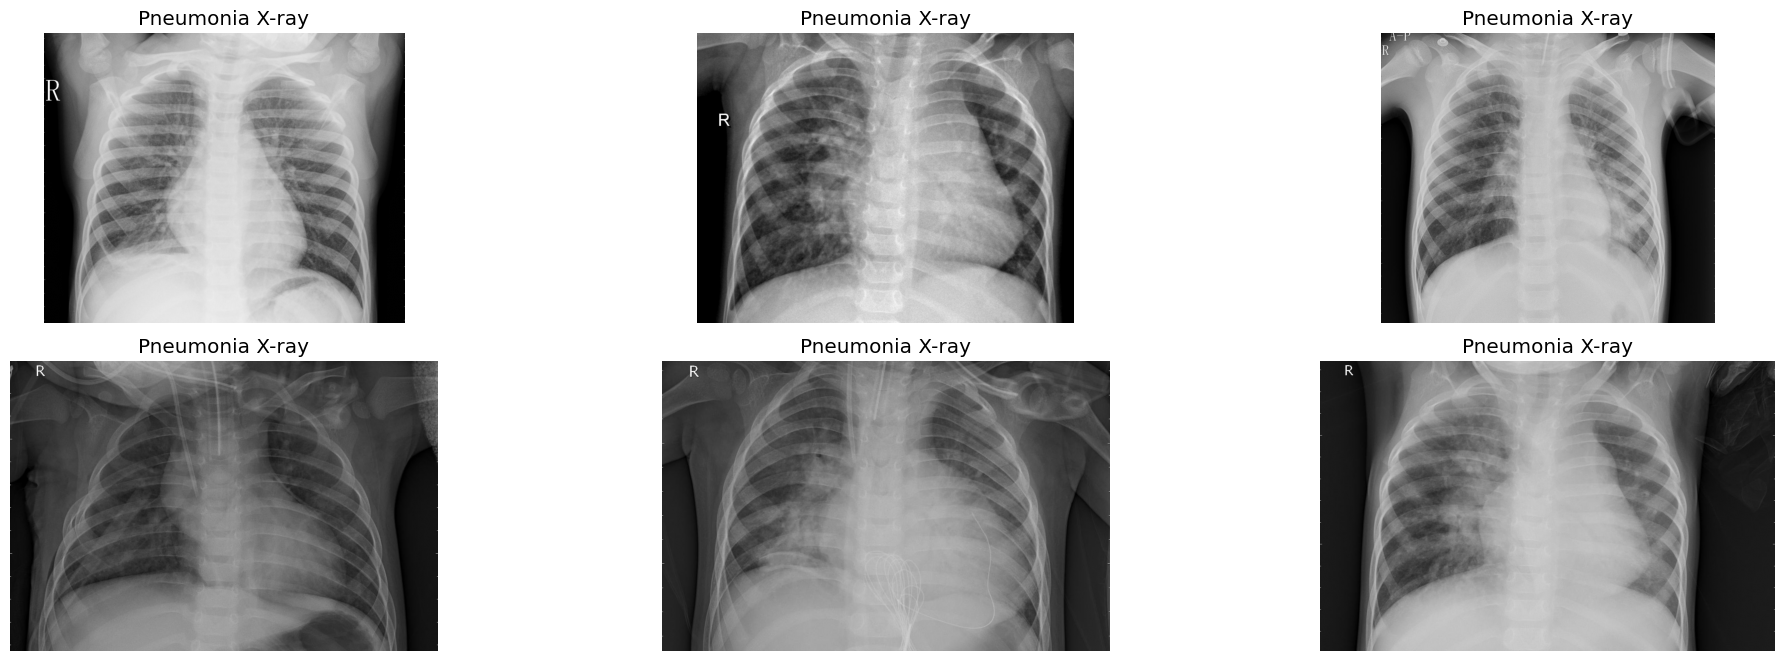

In [6]:
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()
plt.show()

In [7]:
normal = os.listdir("/content/drive/MyDrive/DL/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/DL/chest_xray/train/NORMAL"

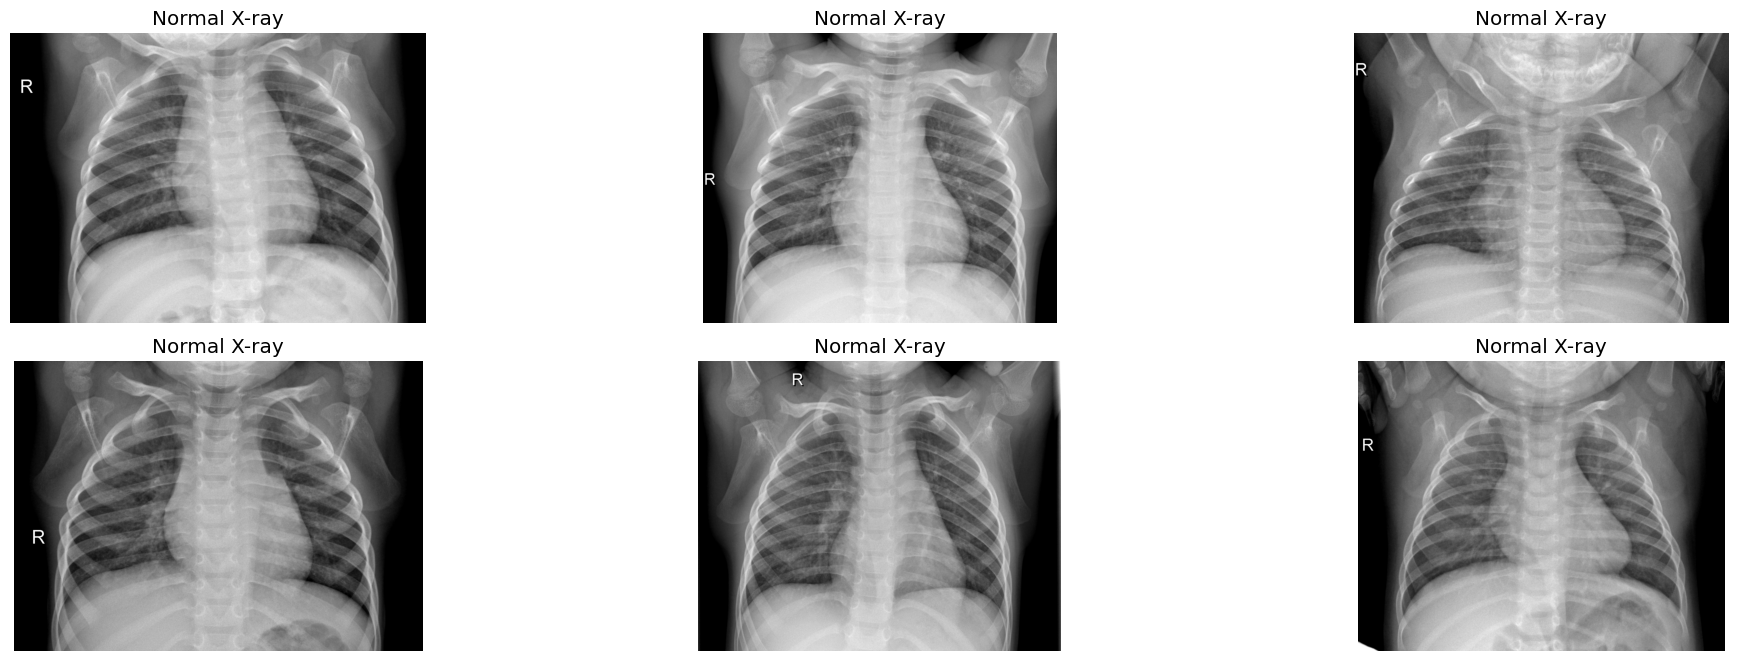

In [8]:
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()
plt.show()

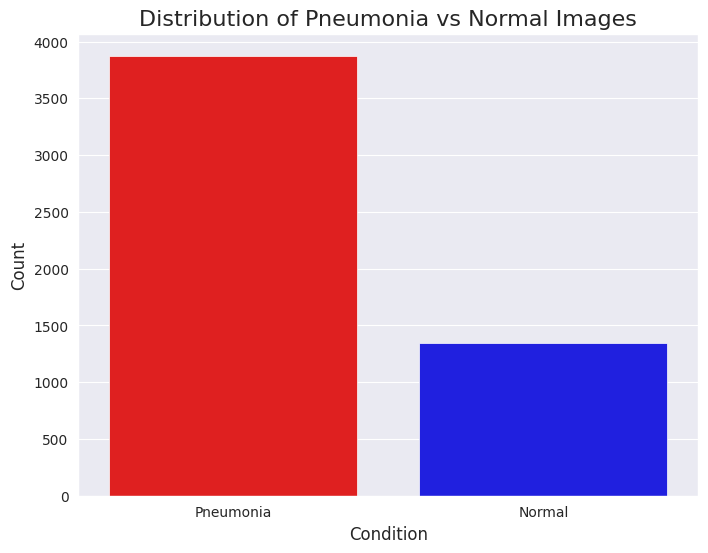

In [9]:

# Assuming `train_labels` contains the labels (0 for Pneumonia, 1 for Normal)
# Map 0 to 'Pneumonia' and 1 to 'Normal'
labels = ['Pneumonia' if label == 0 else 'Normal' for label in train_labels]

# Convert the list to a pandas Series to avoid the FutureWarning
labels_series = pd.Series(labels)

# Set Seaborn style
sns.set_style('darkgrid')

# Create the countplot with different colors for the bars, using hue
plt.figure(figsize=(8, 6))
sns.countplot(x=labels_series, hue=labels_series, palette={'Pneumonia': 'red', 'Normal': 'blue'}, legend=False)

# Add labels and title to the plot
plt.title('Distribution of Pneumonia vs Normal Images', fontsize=16)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()



In [ ]:
# Data Augmentation & Resizing

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [11]:
from tensorflow.keras.applications.inception_v3 import preprocess_input  # Import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=0.4,
    vertical_flip=0.4,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    fill_mode="nearest"
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/DL/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("/content/drive/MyDrive/DL/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
class_labels = train_generator.class_indices

In [14]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
class_name = {value:key for (key, value) in class_labels.items()}

In [16]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
# DenseNet121 Architecture

In [17]:
class_labels = train_generator.class_indices
class_name = {value:key for (key, value) in class_labels.items()}

inputs = Input(shape=(128, 128, 3))

base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=inputs)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 64,868,002 (247.45 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels, **kwargs):
        super().__init__(**kwargs)  # Fix for PyDataset warning
        self.data = data
        self.labels = labels



In [20]:
from keras.saving import save_model
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

history_01 = model_01.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    callbacks=[es, cp, lrr],
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

import os


save_dir = "/content/drive/MyDrive/DL/Google_Net/"


if not os.path.exists(save_dir):
        os.makedirs(save_dir)


save_model(model_01, os.path.join(save_dir, "model_02.h5"))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 582ms/step - accuracy: 0.7712 - loss: 0.5727 - val_accuracy: 0.8125 - val_loss: 0.3859 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 513ms/step - accuracy: 0.8653 - loss: 0.3543 - val_accuracy: 0.8125 - val_loss: 0.3770 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.8652 - loss: 0.3200 - val_accuracy: 0.7500 - val_loss: 0.4523 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - accuracy: 0.8729 - loss: 0.2988 - val_accuracy: 0.7500 - val_loss: 0.4513 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 487ms/step - accuracy: 0.8742 - loss: 0.3015 - val_accuracy: 0.7500 - val_loss: 0.5482 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 494ms/step - accuracy: 0.8753 - loss: 0.2903 - val_accuracy: 0.7500 - val_loss: 0.4732 - learning_rate: 1.0000e-04
Epoch 6: early stopping


In [21]:
if not os.path.isdir('/content/drive/MyDrive/DL/Google_Net/model_weights'):
    os.mkdir("/content/drive/MyDrive/DL/Google_Net/model_weights")
model_01.save(filepath = "/content/drive/MyDrive/DL/Google_Net/model_weights/inceptionv3_model_01.keras", overwrite=True)  # Changed filename

In [22]:
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/DL/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 625 images belonging to 2 classes.


In [26]:
model_01.load_weights("/content/drive/MyDrive/DL/Google_Net/model_weights/inceptionv3_model_01.keras")

inceptionv3_val_eval_01 = model_01.evaluate(valid_generator)  # Changed variable name
inceptionv3_test_eval_01 = model_01.evaluate(test_generator)  # Changed variable name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7500 - loss: 0.4732
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 592ms/step - accuracy: 0.7666 - loss: 0.6000


In [27]:
print(f"Validation Loss: {inceptionv3_val_eval_01[0]}")
print(f"Validation Accuarcy: {inceptionv3_val_eval_01[1]}")
print(f"Test Loss: {inceptionv3_test_eval_01[0]}")
print(f"Test Accuarcy: {inceptionv3_test_eval_01[1]}")

Validation Loss: 0.473194420337677
Validation Accuarcy: 0.75
Test Loss: 0.5984141826629639
Test Accuarcy: 0.7519999742507935


In [ ]:
# Increamental unfreezing & fine tuning

In [28]:
# base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(128, 128, 3))  # Changed to InceptionV3
# base_model_layer_names = [layer.name for layer in base_model.layers]
inputs = tf.keras.layers.Input(shape=(128, 128, 3))
base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=inputs)  # Changed to InceptionV3

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

# Assuming 'model_01' is your original trained model
model_02 = Model(base_model.inputs, output)
model_02.set_weights(model_01.get_weights()) # Directly set weights  # Changed filename

set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith('mixed'):  # Unfreeze layers starting with 'mixed'
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 63, 63, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 63, 63, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 63, 63, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 61, 61, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 61, 61, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 61, 61, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 61, 61, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 61, 61, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 61, 61, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 30, 30, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 30, 30, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 30, 30, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 64,868,002 (247.45 MB)

 Trainable params: 64,405,858 (245.69 MB)

 Non-trainable params: 462,144 (1.76 MB)

None


In [30]:
base_model


<Functional name=inception_v3, built=True>

In [31]:
sgd = SGD(learning_rate=0.0001, weight_decay=1e-6, momentum=0.5, nesterov=True)  # Use weight_decay

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [32]:
history_02 = model_02.fit(train_generator,
            steps_per_epoch=10,
            epochs=1,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_981']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6626 - loss: 0.6041 - val_accuracy: 0.8125 - val_loss: 0.6189 - learning_rate: 1.0000e-04


In [33]:
if not os.path.isdir('/content/drive/MyDrive/DL/Google_Net/model_weights'):
    os.mkdir("/content/drive/MyDrive/DL/Google_Net/model_weights")
model_02.save(filepath = "/content/drive/MyDrive/DL/Google_Net/model_weights/inceptionv3_model_02.keras", overwrite=True)  # Changed filename

In [34]:
model_02.load_weights("/content/drive/MyDrive/DL/Google_Net/model_weights/inceptionv3_model_02.keras")  # Changed filename

inceptionv3_val_eval_02 = model_02.evaluate(valid_generator)  # Changed variable name
inceptionv3_test_eval_02 = model_02.evaluate(test_generator)  # Changed variable name

print(f"Validation Loss: {inceptionv3_val_eval_02[0]}")
print(f"Validation Accuarcy: {inceptionv3_val_eval_02[1]}")
print(f"Test Loss: {inceptionv3_test_eval_02[0]}")
print(f"Test Accuarcy: {inceptionv3_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8125 - loss: 0.6189
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 413ms/step - accuracy: 0.7412 - loss: 0.6219
Validation Loss: 0.6188850402832031
Validation Accuarcy: 0.8125
Test Loss: 0.5833847522735596
Test Accuarcy: 0.7599999904632568


In [ ]:
# Unfreezing and fine tuning the entire network

In [36]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(128, 128, 3))  # Changed to InceptionV3

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("/content/drive/MyDrive/DL/Google_Net/model_weights/inceptionv3_model_02.keras")  # Changed filename

print(model_03.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 63, 63, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 63, 63, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 63, 63, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 61, 61, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 61, 61, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 61, 61, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 61, 61, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 61, 61, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 30, 30, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 30, 30, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 30, 30, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 64,868,002 (247.45 MB)

 Trainable params: 64,833,570 (247.32 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [37]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.5, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [38]:
history_03 = model_02.fit(train_generator,
            steps_per_epoch=100,
            epochs=1,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 537ms/step - accuracy: 0.7170 - loss: 0.5852 - val_accuracy: 0.5625 - val_loss: 0.8208 - learning_rate: 1.0000e-04
